### Data is first saved into a txt file; then being converted into a CSV to have a first look.

In [34]:
import pandas as pd
import ast

# Load raw two-column file
df = pd.read_csv("input.txt")

# Function to convert the string list into a flat dictionary
def expand_record(cell):
    # Convert the string "[{...}, {...}]" into python list of dicts
    items = ast.literal_eval(cell)
    # Merge list of single-pair dicts into one dict
    merged = {}
    for d in items:
        merged.update(d)
    return merged

# Expand both pay1 and pay2
pay1_expanded = df['pay1'].apply(expand_record).apply(pd.Series)
pay2_expanded = df['pay2'].apply(expand_record).apply(pd.Series)

# Prefix columns
pay1_expanded = pay1_expanded.add_prefix("pay1_")
pay2_expanded = pay2_expanded.add_prefix("pay2_")

# Combine everything together
final_df = pd.concat([pay1_expanded, pay2_expanded], axis=1)

# Export to CSV
final_df.to_csv("output.csv", index=False)

print("Saved as output.csv")


Saved as output.csv


### Looking at the data, it can be seen that there are duplicate columns and values are over both of them. Next step is to cobine these columns and values to make sure each column is unique.

In [40]:
import pandas as pd

# Load and normalise headers 
df = pd.read_csv("output.csv", dtype=str)  # read as str to avoid dtype surprises
# strip whitespace and lower-case headers
new_cols = [c.strip().lower() for c in df.columns]
df.columns = new_cols

# collapse exact duplicate column names (keep first non-null across duplicates)
unique_names_in_order = []
seen = set()
for name in df.columns:
    if name not in seen:
        unique_names_in_order.append(name)
        seen.add(name)

collapsed = pd.DataFrame(index=df.index)  # build a new DataFrame with unique column names
for name in unique_names_in_order:
    # select all columns that exactly match this name (could be multiple)
    same_name_mask = [c == name for c in df.columns]
    same_cols = df.loc[:, same_name_mask]
    if same_cols.shape[1] == 1:
        # single column, copy over
        collapsed[name] = same_cols.iloc[:, 0]
    else:
        # multiple columns with the same header name -> merge left-to-right keeping first non-null
        collapsed[name] = same_cols.bfill(axis=1).iloc[:, 0]

# Now 'collapsed' has unique column names (exact header strings) - but still includes variants/typos.

#  define mapping of canonical_name -> list of variant names (do NOT include canonical itself in variants) 
column_mapping = {
    'pay1_shift_loading': ['pay1_shift_load', 'pay1_shiftload', 'pay1_shift_loading_old'],
    'pay1_base_pay': ['pay1_bese_pay', 'pay1_basepay'],
    'pay1_kiwi_saver_employee': ['pay1_kiwi sever employee', 'pay1_kiwi saver employee', 'pay1_kiwi-saver-employee'],
    'pay1_ird_number': ['pay1_ird_no', 'pay1_ird_nopay2_emp_no'],
    'pay2_emp_number': ['pay2_emp_numbar', 'pay2_emp_no'],
    'pay2_future_total_positions': ['pay2_future_total_postions']
    # add other mappings you expect
}

# Lowercase mapping keys & variants (headers already lowercased)
column_mapping = {k.lower(): [v.lower() for v in vals] for k, vals in column_mapping.items()}

# merge variants into canonical columns 
cleaned = collapsed.copy()

for canonical, variants in column_mapping.items():
    # collect existing columns that are either the canonical itself OR any of the variants
    existing = [col for col in cleaned.columns if (col == canonical) or (col in variants)]
    if not existing:
        # nothing to do if neither canonical nor variants present
        continue

    # create/overwrite canonical column with first non-null value across existing columns
    if len(existing) == 1:
        # just ensure canonical exists and is in place (if existing[0] == canonical it's already fine)
        cleaned[canonical] = cleaned[existing[0]]
    else:
        cleaned[canonical] = cleaned[existing].bfill(axis=1).iloc[:, 0]

    # drop all variant columns except the canonical (if canonical wasn't present originally, keep the new one and drop all existing)
    cols_to_drop = [c for c in existing if c != canonical]
    if cols_to_drop:
        cleaned.drop(columns=cols_to_drop, inplace=True)

# final tidy (optional) 
# reorder or rename columns as you prefer; remove leading/trailing spaces in values
cleaned = cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Export cleaned CSV
cleaned.to_csv("cleaned_data.csv", index=False)
print("Saved cleaned_data.csv with", len(cleaned.columns), "columns.")


Saved cleaned_data.csv with 12 columns.


/var/folders/gs/nsc53bv90r1ghqzzq7v837sw0000gn/T/ipykernel_15993/1852846501.py:69: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned = cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### Data is now looking good. Can start working on calculation and final clean up now.

In [41]:
import pandas as pd
import numpy as np
from scipy import stats

# Load cleaned data 
df = pd.read_csv("cleaned_data.csv")

# Ensure numeric columns 
numeric_cols = ['pay1_base_pay','pay1_shift_loading','pay1_net','pay1_ird_number','pay1_future_total_positions',
                'pay2_base_pay','pay2_shift_loading','pay2_net','pay2_sg','pay2_emp_number','pay2_future_total_positions',
                'pay1_kiwi_saver_employee']

# Remove commas, convert to numeric
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').replace('', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Deduplicate rows based on employee + IRD 
df['unique_id'] = df['pay2_emp_number'].astype(str) + '_' + df['pay1_ird_number'].astype(str)

# Aggregate duplicates: keep lowest amounts for conflicting data
agg_dict = {col: 'min' for col in numeric_cols}
df_dedup = df.groupby('unique_id', as_index=False).agg(agg_dict)

# Initialize audit columns
df_dedup['Used?'] = 'Yes'
df_dedup['Reason Not Used'] = ''

# Validate net pay (simplified) 
# For safety, we will allow small discrepancies (< $1) and skip strict validation
# Replace with actual tax calculation if available

# Check for NaNs in net/gross
mask_invalid = df_dedup[['pay1_net','pay2_net','pay1_base_pay','pay2_base_pay']].isna().any(axis=1)
df_dedup.loc[mask_invalid, 'Used?'] = 'No'
df_dedup.loc[mask_invalid, 'Reason Not Used'] = 'Missing net or gross pay'

# Prepare NZ in AUD 
nzd_to_aud = 0.9174  # example RBA average rate
df_dedup['pay1_net_aud'] = df_dedup['pay1_net'] * nzd_to_aud
df_dedup['pay1_base_pay_aud'] = df_dedup['pay1_base_pay'] * nzd_to_aud

# Prepare audit table 
audit_cols = ['pay1_ird_number','pay2_emp_number',
              'pay2_base_pay','pay2_net',
              'pay1_base_pay','pay1_net_aud',
              'Used?','Reason Not Used']

audit_table = df_dedup[audit_cols]
audit_table.to_csv("audit_table.csv", index=False)

# Future cost calculations using only 'Used' rows 
used_rows = df_dedup[df_dedup['Used?']=='Yes']

# If no rows are used, fallback to all rows
if used_rows.empty:
    used_rows = df_dedup.copy()

# Calculate future costs
used_rows['pay1_future_cost_aud'] = used_rows['pay1_future_total_positions'] * used_rows['pay1_net_aud']
used_rows['pay2_future_cost_aud'] = used_rows['pay2_future_total_positions'] * used_rows['pay2_net']

total_current_cost = used_rows['pay1_future_cost_aud'].sum() + used_rows['pay2_future_cost_aud'].sum()

# Scenario 1: Shift NZ future positions to AUS average
avg_aus_net = used_rows['pay2_net'].mean()
used_rows['scenario1_cost'] = used_rows['pay1_future_total_positions'] * avg_aus_net + used_rows['pay2_future_cost_aud']
total_scenario1 = used_rows['scenario1_cost'].sum()
saving1 = total_current_cost - total_scenario1

# Scenario 2: Shift AUS future positions to NZ average (AUD)
avg_nz_net_aud = used_rows['pay1_net_aud'].mean()
used_rows['scenario2_cost'] = used_rows['pay2_future_total_positions'] * avg_nz_net_aud + used_rows['pay1_future_cost_aud']
total_scenario2 = used_rows['scenario2_cost'].sum()
saving2 = total_current_cost - total_scenario2

# Statistical test for gross pay (AUD) 
nz_gross_aud = used_rows['pay1_net_aud']
aus_gross_aud = used_rows['pay2_net']

# Only perform t-test if both samples have at least 2 rows
if len(nz_gross_aud) >= 2 and len(aus_gross_aud) >= 2:
    t_stat, p_val = stats.ttest_ind(nz_gross_aud, aus_gross_aud, equal_var=False)
else:
    t_stat, p_val = np.nan, np.nan

# Print summary 
print(f"Current total future cost (AUD): {total_current_cost:,.2f}")
print(f"Scenario 1 (NZ to AUS) cost: {total_scenario1:,.2f}, saving: {saving1:,.2f} AUD")
print(f"Scenario 2 (AUS to NZ) cost: {total_scenario2:,.2f}, saving: {saving2:,.2f} AUD")
print(f"T-test for gross pay: t={t_stat}, p={p_val}")
if pd.notna(p_val):
    if p_val < 0.05:
        print("Significant difference in gross pay between NZ and AUS")
    else:
        print("No significant difference in gross pay between NZ and AUS")
else:
    print("Not enough data to perform t-test")


Current total future cost (AUD): 9,087,033.33
Scenario 1 (NZ to AUS) cost: 10,192,984.94, saving: -1,105,951.61 AUD
Scenario 2 (AUS to NZ) cost: 14,811,943.05, saving: -5,724,909.72 AUD
T-test for gross pay: t=1.1771462344503427, p=0.24294715399765746
No significant difference in gross pay between NZ and AUS


### Graphing purpose for presentation

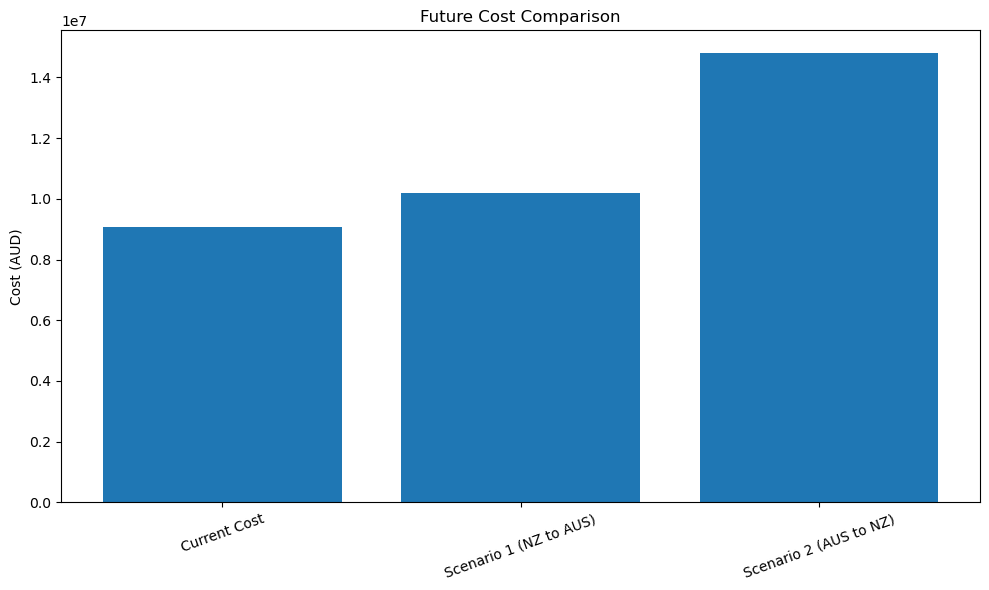

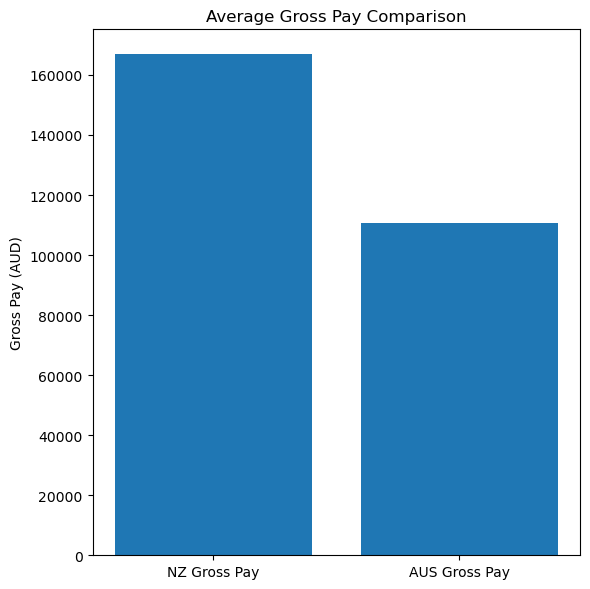

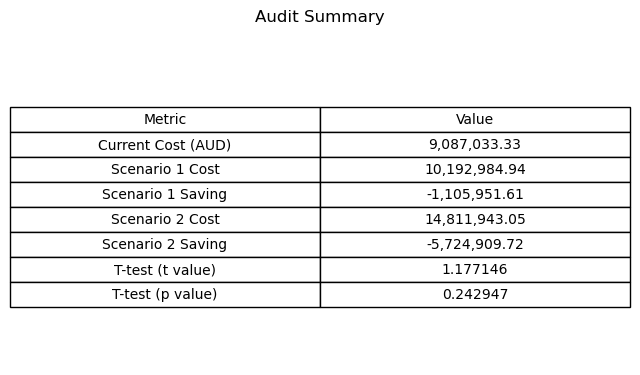

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load cleaned dataset
df = pd.read_csv("cleaned_data.csv")

nz_pay_col = "pay1_base_pay"
aus_pay_col = "pay2_base_pay"

# Calculate averages (ignore missing values)
avg_pay_nz = df[nz_pay_col].mean(skipna=True)
avg_pay_aus = df[aus_pay_col].mean(skipna=True)

current_cost = 9087033.33

scenario1_cost = 10192984.94
scenario1_saving = -1105951.61

scenario2_cost = 14811943.05
scenario2_saving = -5724909.72

t_value = 1.1771462344503427
p_value = 0.24294715399765746

# Bar Chart: Current vs Scenario Costs
labels = ['Current Cost', 'Scenario 1 (NZ to AUS)', 'Scenario 2 (AUS to NZ)']
values = [current_cost, scenario1_cost, scenario2_cost]

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.title("Future Cost Comparison")
plt.ylabel("Cost (AUD)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Bar Chart: Average Gross Pay (NZ vs AUS)
plt.figure(figsize=(6, 6))
plt.bar(['NZ Gross Pay', 'AUS Gross Pay'], [avg_pay_nz, avg_pay_aus])
plt.title("Average Gross Pay Comparison")
plt.ylabel("Gross Pay (AUD)")
plt.tight_layout()
plt.show()

# Audit Summary Table Chart
audit_data = {
    "Metric": [
        "Current Cost (AUD)",
        "Scenario 1 Cost",
        "Scenario 1 Saving",
        "Scenario 2 Cost",
        "Scenario 2 Saving",
        "T-test (t value)",
        "T-test (p value)"
    ],
    "Value": [
        f"{current_cost:,.2f}",
        f"{scenario1_cost:,.2f}",
        f"{scenario1_saving:,.2f}",
        f"{scenario2_cost:,.2f}",
        f"{scenario2_saving:,.2f}",
        f"{t_value:.6f}",
        f"{p_value:.6f}"
    ]
}

audit_df = pd.DataFrame(audit_data)

plt.figure(figsize=(8, 2 + len(audit_df) * 0.3))
plt.axis('tight')
plt.axis('off')

table = plt.table(
    cellText=audit_df.values,
    colLabels=audit_df.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.title("Audit Summary", pad=20)
plt.show()
